In [1]:
import sys
sys.path.append("../code/cv")

from evaluate import *
from parse_layout import *
from matplotlib import pyplot as plt

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
xml_files = glob.glob("../data/labels/val/*.xml")
print(f"Found {len(xml_files)} files.")

label = parse_label_xml(xml_files[0])
print(label)

name_labels = dict(map(parse_label_xml, xml_files))

Found 199 files.
('000963-20190830-0.jpg', [('text', (602, 376, 1573, 2219)), ('title', (662, 183, 1505, 358))])


In [41]:
# layout_path = "../data/layout/PrimaLayout-mask_rcnn_R_50_FPN_3x"
layout_path = "../data/layout/HJDataset-faster_rcnn_R_50_FPN_3x"


imgs_dir = "../data/jpgs/"

def prepare_data(layout_path):
    layout = pickle.load(open(layout_path, "rb"))
    data = []
    for item in layout:
        imname = os.path.basename(item["path"])
        if imname not in name_labels:
            continue

        item["path"] = os.path.join(imgs_dir, os.path.basename(item["path"]))
        item["title"] = []
        item["text"] = []

        label = name_labels[imname]

        for cls, rect in label:
            l,t,r,b = rect
            l /= item["w"]
            r /= item["w"]
            t /= item["h"]
            b /= item["h"]

            item[cls].append([l,t,r,b])

        data.append(item)
    
    return data
    
data = prepare_data(layout_path)

print(f"Merge {len(data)} items.")
print(data[0])

Merge 199 items.
{'path': '../data/jpgs/000001-20200828-0.jpg', 'h': 2201, 'w': 1701, 'layout': [(0.20414833459063603, 0.3258325350604129, 0.23787327250055115, 0.41552562444982394, 'Title Region', 0.4992178976535797), (0.8163007571373457, 0.06510686116129742, 0.9011828261638375, 0.12235431593150131, 'Title Region', 0.2409660667181015), (0.42054858872078926, 0.2875102492475011, 0.43800144991686873, 0.3394224382649222, 'Title', 0.23803533613681793)], 'title': [[0.10464432686654909, 0.20990458882326216, 0.9035861258083481, 0.24716038164470694]], 'text': [[0.3862433862433862, 0.2612448886869605, 0.9335684891240447, 0.9004997728305316]]}


../data/jpgs/000001-20200828-0.jpg


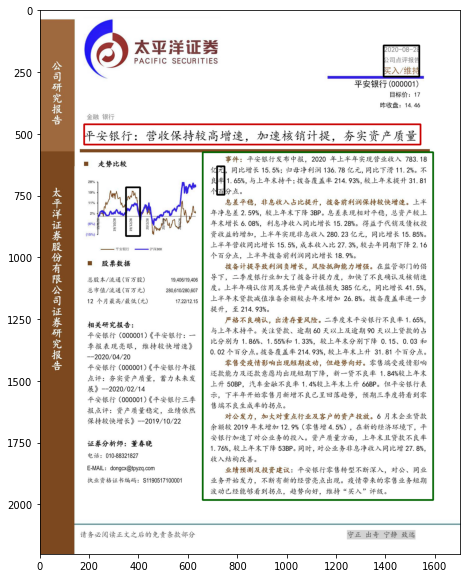

In [43]:
colors = {"text": (0,100,0), "title": (200,0,0)}

k = 0

item = data[k]
print(item["path"])

canvas = cv2.imread(item["path"])

show_bbxes_on(canvas, item["layout"], show=False, color=0)

show_bbxes_on(canvas, item["title"], show=False, color=(200,0,0))
show_bbxes_on(canvas, item["text"], show=False, color=(0,100,0))

plt.figure(figsize=(8,10))
plt.axis('on')
plt.imshow(canvas)
plt.show()

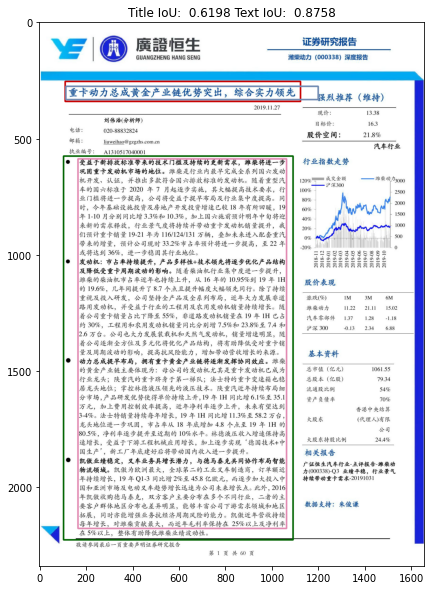

In [11]:
h_ioa, h_rect = cal_accumulated_iox([t[:4] for t in item["layout"]], item["title"][0], offset=0, joint_thresh=0.2)
t_ioa, t_rect = cal_accumulated_iox([t[:4] for t in item["layout"]], item["text"][0], offset=0, joint_thresh=0.01)


canvas = cv2.imread(item["path"])
show_bbxes_on(canvas, item["title"], show=False, color=(200,0,0))
show_bbxes_on(canvas, [h_rect], show=False, color=(112, 138, 178))

show_bbxes_on(canvas, item["text"], show=False, color=(0,100,0))
show_bbxes_on(canvas, [t_rect], show=False, color=(226, 138, 178))

plt.figure(figsize=(8,10))
plt.title(f"Title IoU: {h_ioa: .4f} Text IoU: {t_ioa: .4f}")
plt.axis('on')
plt.imshow(canvas)
plt.show()

100%|██████████| 199/199 [00:00<00:00, 2806.17it/s]


(array([12.,  3.,  6., 11., 28., 49., 39., 36., 12.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

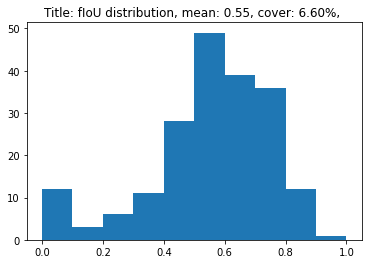

In [32]:
from tqdm import tqdm

def count_title_stat(data):
    title_ioas = []
    for i,item in enumerate(tqdm(data)):
        pred = [t[:4] for t in item["layout"]]
        if len(item["title"]) != 1:
#             print(f"Index {i}: invalid label!")
            continue

        gt = item["title"][0]
        title_ioas.append(cal_accumulated_iox(pred, gt, offset=0, joint_thresh=0.2)[0])
    
    title_ioas = np.array(title_ioas)
    cover_rate = (title_ioas > 0.8).mean()
    
    return title_ioas, title_ioas.mean(), cover_rate

title_ioas, mean, cover_rate = count_title_stat(data)
plt.title(f"Title: fIoU distribution, mean: {mean:.2f}, cover: {cover_rate:.2%}, ")
plt.hist(title_ioas, bins=10, range=[0,1])

100%|██████████| 199/199 [00:00<00:00, 2904.34it/s]


(array([ 0.,  0.,  1.,  1.,  0.,  0.,  2., 21., 92., 87.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

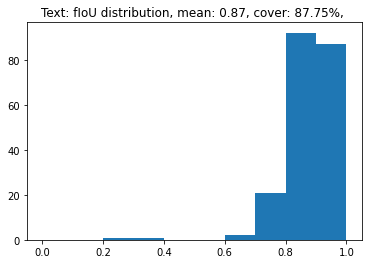

In [33]:
def count_text_stat(data):
    text_ioas = []
    for i,item in enumerate(tqdm(data)):
        pred = [t[:4] for t in item["layout"]]
        if len(item["text"]) == 0:
#             print(f"Index {i}: invalid label!")
            continue

        for gt in item["text"]:
            text_ioas.append(cal_accumulated_iox(pred, gt, offset=0, joint_thresh=0.01)[0])
    
    text_ioas = np.array(text_ioas)
    cover_rate = (text_ioas > 0.8).mean()
    
    return text_ioas, text_ioas.mean(), cover_rate

text_ioas,mean, cover_rate = count_text_stat(data)
plt.title(f"Text: fIoU distribution, mean: {mean:.2f}, cover: {cover_rate:.2%}, ")
plt.hist(text_ioas, bins=10, range=[0,1])

In [36]:
def run_stats():
    layouts = glob.glob("../data/layout/*")
    layouts.sort()
    
    for path in layouts:
        data = prepare_data(path)        
        title_ioas, m1, c1 = count_title_stat(data)
        text_ioas,m2, c2 = count_text_stat(data)

        print(os.path.basename(path))
        print(f"title: {m1: .2f} {c1 :.2%}")
        print(f"text: {m2: .2f} {c2:.2%}")
        
run_stats()

  0%|          | 0/199 [00:00<?, ?it/s]

HJDataset-faster_rcnn_R_50_FPN_3x
title:  0.01 0.00%
text:  0.31 13.73%
HJDataset-mask_rcnn_R_50_FPN_3x
title:  0.00 0.00%
text:  0.21 7.84%


  0%|          | 0/199 [00:00<?, ?it/s]

HJDataset-retinanet_R_50_FPN_3x
title:  0.00 0.00%
text:  0.19 8.33%
NewspaperNavigator-faster_rcnn_R_50_FPN_3x
title:  0.00 0.51%
text:  0.00 0.00%
PrimaLayout-mask_rcnn_R_50_FPN_3x
title:  0.55 6.60%
text:  0.87 87.75%


  0%|          | 0/199 [00:00<?, ?it/s]

PubLayNet-faster_rcnn_R_50_FPN_3x
title:  0.45 4.57%
text:  0.87 86.76%
PubLayNet-mask_rcnn_R_50_FPN_3x
title:  0.37 5.58%
text:  0.84 81.37%


100%|██████████| 199/199 [00:00<00:00, 2399.38it/s]

PubLayNet-mask_rcnn_X_101_32x8d_FPN_3x
title:  0.38 6.60%
text:  0.82 80.39%
